# Neural Networks

This notebook is a simple introduction to neural networks. 

We will first use the `scikit-learn` library to create a simple neural network model to classify the MNIST dataset. For more information, you can check the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

Then, we will use the `pytorch` library to create a more complex neural network model to classify the MNIST dataset. For more information, you can check the [documentation](https://pytorch.org/docs/stable/index.html).

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Data

We use MNIST dataset which is a dataset of 28x28 pixel handwritten digits, leading to 784 features in the dataset. Therefore the first layer weight matrix has the shape (784, hidden_layer_sizes[0]).

<!-- To make the example run faster, we use very few hidden units, and train only for a very short time. Training longer would result in weights with a much smoother spatial appearance. The example will throw a warning because it doesn’t converge, in this case this is what we want because of resource usage constraints on our Continuous Integration infrastructure that is used to build this documentation on a regular basis. -->

In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

# Load data from https://www.openml.org/d/554
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')

# We scale X from [0, 255] to [0, 1].
X /= 255.0

# Split data into train and test partition
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.7)

# Shape of the data
print(f"Data size: {mnist.data.shape}")

Data size: (70000, 784)


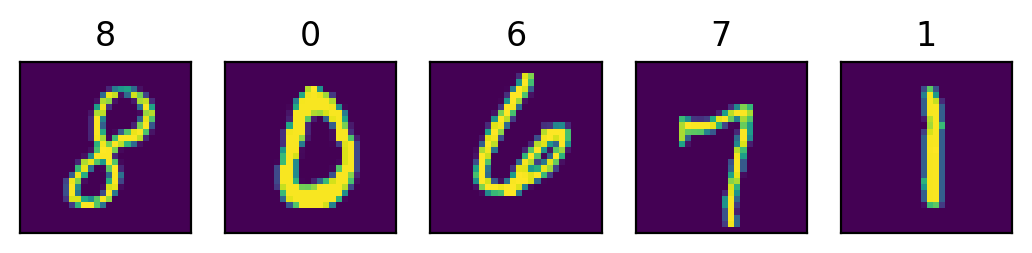

In [3]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

plot_example(X_train, y_train)

## Multi-layer Perceptron

Multi-layer Perceptron (MLP) is a supervised learning algorithm that learns a function $f: R^m \rightarrow R^o$ by training on a dataset, where $m$ is the number of dimensions for input and $o$ is the number of dimensions for output. 

Given a set of features $X=x_1, x_2, \ldots, x_m$ and a target $y$, it can learn a non-linear function approximator for either classification or regression. It is different from logistic regression, in that between the input and the output layer, there can be one or more non-linear layers, called hidden layers.

<img src="https://scikit-learn.org/1.5/_images/multilayerperceptron_network.png" alt="drawing" width="250"/>

The leftmost layer, known as the input layer, consists of a set of neurons $\left\{x_i \mid x_1, x_2, \ldots, x_m\right\}$ representing the input features. 

Each neuron in the hidden layer transforms the values from the previous layer with a weighted linear summation $w_1 x_1+w_2 x_2+\ldots+w_m x_m$, followed by a non-linear activation function $g(\cdot): R \rightarrow R$ - like the hyperbolic tan function. 

The output layer receives the values from the last hidden layer and transforms them into output values.

In [4]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(40,),  # number of neurons in the ith hidden layer
    max_iter=8,  # solver iterates until convergence or this number of iterations
    alpha=1e-4,  # L2 penalty (regularization term) parameter
    solver="sgd",  # solver for weight optimization: stochastic gradient descent
    learning_rate_init=0.2,  # controls the step-size in updating the weights
    verbose=True,
    random_state=42,
)

mlp.fit(X_train, y_train)

print("Training set score: %f" % mlp.score(X_train, y_train))
print("Test set score: %f" % mlp.score(X_test, y_test))

Iteration 1, loss = 0.43876685
Iteration 2, loss = 0.18161919
Iteration 3, loss = 0.13374560
Iteration 4, loss = 0.10868498
Iteration 5, loss = 0.09370375
Iteration 6, loss = 0.07700252
Iteration 7, loss = 0.06711730
Iteration 8, loss = 0.05946887
Training set score: 0.988619
Test set score: 0.955735


### Main Parameters
- `hidden_layer_sizes`: The number of neurons in the hidden layer.
- `activation`: The activation function for the hidden layer.
- `solver`: The solver for weight optimization.
- `alpha`: The L2 penalty (regularization term) parameter.
- `learning_rate_init`: It controls the step-size in updating the weights.

### Tips on Practical Use
- Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data.
- Finding a reasonable regularization parameter $\alpha$ is best done using GridSearchCV.
- Empirically, we observed that L-BFGS converges faster and with better solutions on small datasets. For relatively large datasets, however, Adam is very robust.

### Visualizing Neural Networks
To visualize the working of a neural network, we can use [Tensorflow Playground](https://playground.tensorflow.org/), which produced a prediction regression model using a simple single layer neural network model based on two input variables.

## Using PyTorch and skorch

For more information on how to use skorch, you can check the [documentation](https://skorch.readthedocs.io/en/stable/). And for PyTorch, you can check the [documentation](https://pytorch.org/tutorials/beginner/basics/intro.html).

We will build a simple, fully connected neural network with one hidden layer. 

Input layer has 784 dimensions (28x28), hidden layer has 98 (= 784 / 8) and output layer 10 neurons, representing digits 0 - 9.

In [5]:
import torch
from torch import nn, optim
import torch.nn.functional as F

mnist_dim = X.shape[1]
hidden_dim = int(mnist_dim/8)
output_dim = len(np.unique(mnist.target))

print(f"Input dim: {mnist_dim}, Hidden dim: {hidden_dim}, Output dim: {output_dim}")

Input dim: 784, Hidden dim: 98, Output dim: 10


To define a neural network in PyTorch, we create a class that inherits from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).

We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU or MPS if available.

In [6]:
class ClassifierModule(nn.Module):
    def __init__(
            self,
            input_dim=mnist_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.5,
    ):
        super(ClassifierModule, self).__init__()
        self.dropout = nn.Dropout(dropout)

        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [7]:
import skorch

In [8]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = skorch.NeuralNetClassifier(
    ClassifierModule,
    max_epochs=20,
    lr=0.1,
    device=device,
)

In [9]:
net.fit(X_train, y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.2392       0.8571        0.5637  0.3654
      2        0.6047       0.8933        0.3982  0.3180
      3        0.4972       0.9048        0.3435  0.3199
      4        0.4356       0.9167        0.3049  0.3232
      5        0.3972       0.9238        0.2799  0.3167
      6        0.3666       0.9255        0.2627  0.3150
      7        0.3463       0.9298        0.2488  0.3512
      8        0.3200       0.9319        0.2351  0.3200
      9        0.3140       0.9340        0.2239  0.3191
     10        0.3015       0.9348        0.2203  0.3155
     11        0.2833       0.9410        0.2042  0.3152
     12        0.2689       0.9393        0.1987  0.3354
     13        0.2642       0.9433        0.1934  0.3219
     14        0.2555       0.9452        0.1879  0.3148
     15        0.2467       0.9460        0.1833  0.3216
     16        0.2390       0.9

In [10]:
from sklearn.metrics import accuracy_score

y_pred = net.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

Accuracy: 0.9464081632653061


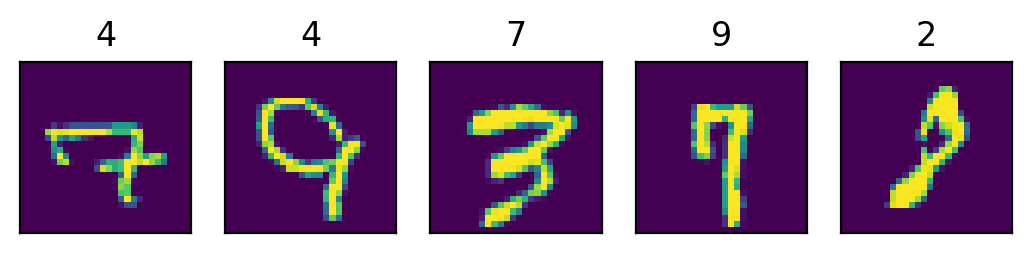

In [11]:
error_mask = y_pred != y_test

plot_example(X_test[error_mask], y_pred[error_mask])